In [174]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link='https://drive.google.com/open?id=1P0RmfHOw3IauLoxWHFbS5f4iG1I5OLEd'

In [177]:
fluff, id = link.split('=')
print (id) 

1P0RmfHOw3IauLoxWHFbS5f4iG1I5OLEd


In [0]:
import pandas as pd

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df = pd.read_csv('Filename.csv')

In [180]:
df.shape

(1752, 16)

In [0]:
df['ratio']=df['dislikes']/df['likes']

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

import os

import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers


In [0]:
def split_text(x):
    x = wordninja.split(x)
    return '-'.join(x)

In [184]:
df["merged"] = df["merged"].str.lower()
print("Train shape : ",df.merged.shape)

Train shape :  (1752,)


In [0]:
 df=df.reindex(np.random.permutation(df.index))

In [0]:
df['ratio']=df['ratio'].fillna(0)

In [187]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2018)
#train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=2018)
print(train_df.shape)
print(test_df.shape)


(1401, 17)
(351, 17)


In [0]:
 ## fill up the missing values
train_X = train_df["merged"].fillna("_##_").values
#val_X = val_df["merged"].fillna("_##_").values
test_X = test_df["merged"].fillna("_##_").values


In [0]:
#here use  df in place of train_x
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df['merged']))
train_X = tokenizer.texts_to_sequences(train_X)
#val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

In [0]:
## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
#val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [0]:
## Get the target values
train_y = train_df['label'].values
test_y = test_df['label'].values 

In [0]:
embedding_link= 'https://drive.google.com/open?id=1i1EVafb-d4SrdQYT_PpLIYq2A2X25Ac_'

In [193]:
fluff, id = embedding_link.split('=')
print (id)

1i1EVafb-d4SrdQYT_PpLIYq2A2X25Ac_


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('wiki-news-300d-1M.vec')  


In [0]:
def load_fasttext(word_index):    
    EMBEDDING_FILE = 'wiki-news-300d-1M.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE,encoding="utf8") if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [0]:
def model_cnn(embedding_matrix):
    filter_sizes = [1,2,3,5]
    num_filters = 36

    inp1 = Input(shape=(maxlen,))
    inp2 = Input(shape=(1,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp1)
    x = Reshape((maxlen, embed_size, 1))(x)

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                     kernel_initializer='he_normal', activation='elu')(x)
        maxpool_pool.append(MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))

    z = Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)
    
    y = Dense(64, activation="relu")(inp2)
    y = Dense(32, activation="relu")(y)
    y = Dense(4, activation="relu")(y)
    

    conc = concatenate([z,y])
    
    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)    


    model = Model(inputs=[inp1,inp2], outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [0]:
def model_lstm_atten(embedding_matrix):
    inp1 = Input(shape=(maxlen,))
    inp2 = Input(shape=(1,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp1)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = Attention(maxlen)(x)
    x = Dense(64, activation="relu")(x)
    
    y = Dense(64, activation="relu")(inp2)
    y = Dense(32, activation="relu")(y)
    y = Dense(4, activation="relu")(y)
    
    conc = concatenate([x,y])
    
    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)

    model = Model(inputs=[inp1,inp2], outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [0]:
def model_gru_ap_atten(embedding_matrix):
    inp1 = Input(shape=(maxlen,))
    inp2 = Input(shape=(1,))
    
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp1)
    #(cuDNN) is a GPU-accelerated library of primitives for deep neural networks
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x = Attention(maxlen)(x) # New
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.1)(x)
    
    y = Dense(64, activation="relu")(inp2)
    y = Dense(32, activation="relu")(y)
    y = Dense(4, activation="relu")(y)
    
    conc = concatenate([x,y])
    
    
    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)

    model = Model(inputs=[inp1,inp2], outputs=outp)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model    


In [0]:
def model_lstm_du(embedding_matrix):
    inp1 = Input(shape=(maxlen,))
    inp2 = Input(shape=(1,))
    
    #1st input
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp1)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    #2nd input
    y = Dense(64, activation="relu")(inp2)
    y = Dense(32, activation="relu")(y)
    y = Dense(4, activation="relu")(y)
   # y = Model(inputs=inp2, outputs=outp)#you can add y also in conc removing model

    conc = concatenate([avg_pool, max_pool,y])
    
    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=[inp1,inp2], outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.summary()
    return model

In [0]:
def model_gru_atten_3(embedding_matrix,):
  
    inp1 = Input(shape=(maxlen,))
    inp2 = Input(shape=(1,))

    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp1)
    x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(100, return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x = Attention(maxlen)(x)

    y = Dense(64, activation="relu")(inp2)
    y = Dense(32, activation="relu")(y)
    y = Dense(4, activation="relu")(y)

    conc = concatenate([x,y])

    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)

    model = Model(inputs=[inp1,inp2], outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [199]:
INPUT2=train_df['ratio'].as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
#Train and predict
def train_pred(model, epochs):
    history=model.fit([train_X,train_df['ratio']], train_y, batch_size=8,epochs=epochs,verbose=1,validation_split=.2)
    #pred_val_y = model.predict([val_X], batch_size=1024, verbose=0)
    #pred_test_y = model.predict([test_X], batch_size=1024, verbose=0)
    #Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    return #pred_val_y, pred_test_y

In [0]:
word_index=tokenizer.word_index

vocab = []
for w,k in word_index.items():
    vocab.append(w)
    if k >= max_features:
        break
    

In [202]:
#embedding_matrix_1 = load_glove(word_index)
embedding_matrix_2 = load_fasttext(word_index)
#embedding_matrix_3 = load_para(word_index)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [206]:
embedding_matrix = np.mean([embedding_matrix_2], axis = 0)
np.shape(embedding_matrix)

(36156, 300)

In [0]:
outputs = []

Train on 1120 samples, validate on 281 samples
Epoch 1/15
1120/1120 [==============================] - 23s 20ms/step - loss: 0.6427 - acc: 0.6500 - val_loss: 0.5978 - val_acc: 0.6726
Epoch 2/15
1120/1120 [==============================] - 12s 11ms/step - loss: 0.4927 - acc: 0.7714 - val_loss: 0.4033 - val_acc: 0.8185
Epoch 3/15
1120/1120 [==============================] - 12s 11ms/step - loss: 0.3660 - acc: 0.8500 - val_loss: 0.3942 - val_acc: 0.7865
Epoch 4/15
1120/1120 [==============================] - 12s 11ms/step - loss: 0.3266 - acc: 0.8696 - val_loss: 0.3349 - val_acc: 0.8541
Epoch 5/15
1120/1120 [==============================] - 12s 11ms/step - loss: 0.3063 - acc: 0.8732 - val_loss: 0.5664 - val_acc: 0.7509
Epoch 6/15
1120/1120 [==============================] - 12s 11ms/step - loss: 0.2934 - acc: 0.8812 - val_loss: 0.4060 - val_acc: 0.8221
Epoch 7/15
1120/1120 [==============================] - 12s 11ms/step - loss: 0.2712 - acc: 0.8866 - val_loss: 0.2983 - val_acc: 0.8612
E

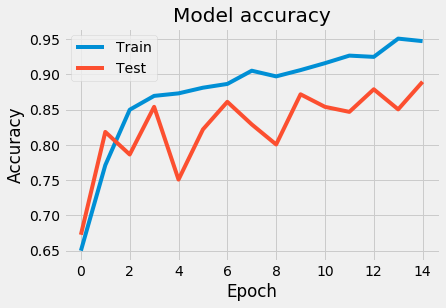

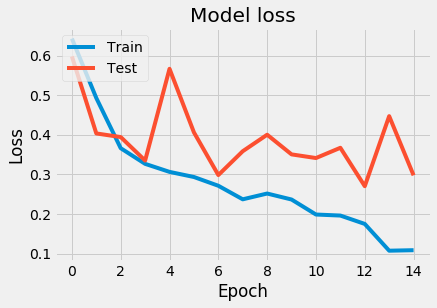

In [225]:
train_pred(model_lstm_atten(embedding_matrix), epochs = 10)

Train on 1120 samples, validate on 281 samples
Epoch 1/12
1120/1120 [==============================] - 29s 26ms/step - loss: 0.6075 - acc: 0.6929 - val_loss: 0.4691 - val_acc: 0.8114
Epoch 2/12
1120/1120 [==============================] - 17s 15ms/step - loss: 0.3622 - acc: 0.8607 - val_loss: 0.3508 - val_acc: 0.8363
Epoch 3/12
1120/1120 [==============================] - 17s 15ms/step - loss: 0.3446 - acc: 0.8563 - val_loss: 0.3500 - val_acc: 0.8541
Epoch 4/12
1120/1120 [==============================] - 17s 15ms/step - loss: 0.3186 - acc: 0.8580 - val_loss: 0.3537 - val_acc: 0.8577
Epoch 5/12
1120/1120 [==============================] - 17s 15ms/step - loss: 0.3052 - acc: 0.8750 - val_loss: 0.3332 - val_acc: 0.8577
Epoch 6/12
1120/1120 [==============================] - 17s 15ms/step - loss: 0.2875 - acc: 0.8821 - val_loss: 0.3473 - val_acc: 0.8505
Epoch 7/12
1120/1120 [==============================] - 17s 15ms/step - loss: 0.2640 - acc: 0.8857 - val_loss: 0.3306 - val_acc: 0.8505
E

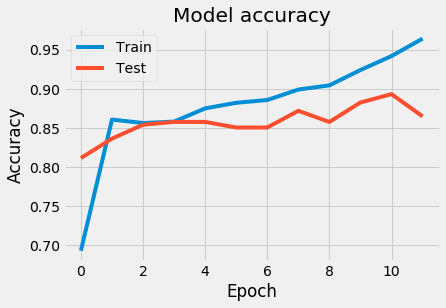

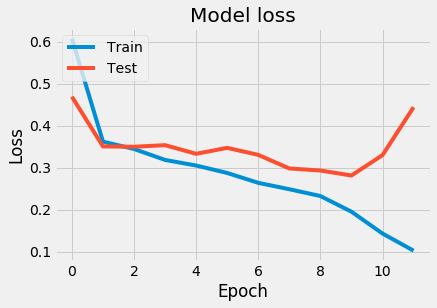

TypeError: ignored

In [226]:
train_pred(model_gru_atten_3(embedding_matrix), epochs = 12)

Train on 1120 samples, validate on 281 samples
Epoch 1/12
1120/1120 [==============================] - 19s 17ms/step - loss: 0.6210 - acc: 0.6670 - val_loss: 0.4811 - val_acc: 0.7865
Epoch 2/12
1120/1120 [==============================] - 7s 7ms/step - loss: 0.3560 - acc: 0.8527 - val_loss: 0.4005 - val_acc: 0.8221
Epoch 3/12
1120/1120 [==============================] - 7s 7ms/step - loss: 0.2228 - acc: 0.9054 - val_loss: 0.4002 - val_acc: 0.8363
Epoch 4/12
1120/1120 [==============================] - 7s 7ms/step - loss: 0.1335 - acc: 0.9366 - val_loss: 0.7348 - val_acc: 0.7865
Epoch 5/12
1120/1120 [==============================] - 7s 7ms/step - loss: 0.0676 - acc: 0.9679 - val_loss: 0.6125 - val_acc: 0.8185
Epoch 6/12
1120/1120 [==============================] - 7s 7ms/step - loss: 0.0185 - acc: 0.9964 - val_loss: 0.6569 - val_acc: 0.8612
Epoch 7/12
1120/1120 [==============================] - 7s 7ms/step - loss: 0.0150 - acc: 0.9955 - val_loss: 0.8164 - val_acc: 0.8399
Epoch 8/12
11

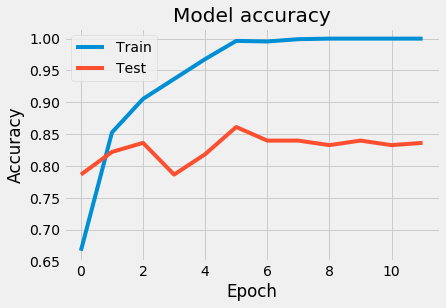

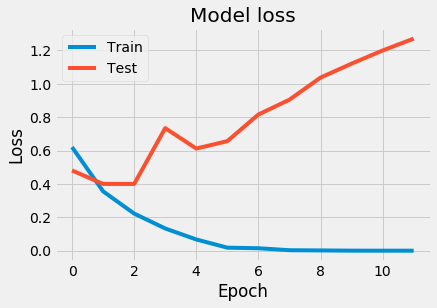

In [227]:
train_pred(model_gru_ap_atten(embedding_matrix), epochs = 12)
#outputs.append([pred_val_y, pred_test_y, 'gru atten ap'])

Train on 1120 samples, validate on 281 samples
Epoch 1/12
1120/1120 [==============================] - 15s 13ms/step - loss: 0.5276 - acc: 0.7188 - val_loss: 0.4249 - val_acc: 0.8007
Epoch 2/12
1120/1120 [==============================] - 3s 3ms/step - loss: 0.2276 - acc: 0.9196 - val_loss: 0.3658 - val_acc: 0.8185
Epoch 3/12
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0536 - acc: 0.9911 - val_loss: 0.2960 - val_acc: 0.8541
Epoch 4/12
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0119 - acc: 1.0000 - val_loss: 0.2734 - val_acc: 0.8826
Epoch 5/12
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0056 - acc: 0.9991 - val_loss: 0.2535 - val_acc: 0.8968
Epoch 6/12
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.2692 - val_acc: 0.8861
Epoch 7/12
1120/1120 [==============================] - 3s 3ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.2848 - val_acc: 0.8826
Epoch 8/12
11

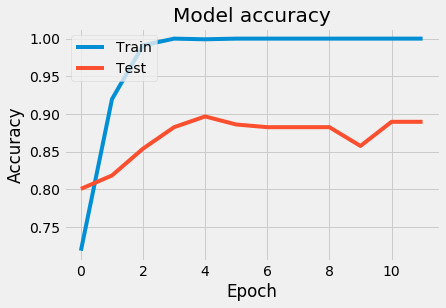

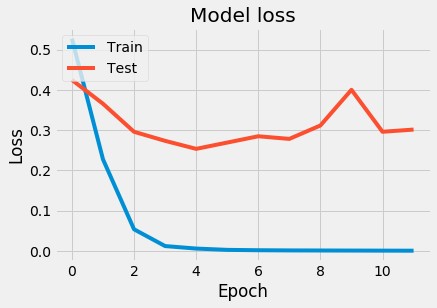

In [228]:
train_pred(model_cnn(embedding_matrix), epochs = 12) # GloVe only
#outputs.append([pred_val_y, pred_test_y, '2d CNN '])

Train on 1120 samples, validate on 281 samples
Epoch 1/12
1120/1120 [==============================] - 19s 17ms/step - loss: 0.5692 - acc: 0.7089 - val_loss: 0.4499 - val_acc: 0.8256
Epoch 2/12
1120/1120 [==============================] - 7s 6ms/step - loss: 0.2901 - acc: 0.8866 - val_loss: 0.3200 - val_acc: 0.8577
Epoch 3/12
1120/1120 [==============================] - 7s 6ms/step - loss: 0.0845 - acc: 0.9804 - val_loss: 0.2915 - val_acc: 0.8826
Epoch 4/12
1120/1120 [==============================] - 7s 6ms/step - loss: 0.0114 - acc: 0.9991 - val_loss: 0.3801 - val_acc: 0.8577
Epoch 5/12
1120/1120 [==============================] - 7s 7ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.5460 - val_acc: 0.8470
Epoch 6/12
1120/1120 [==============================] - 7s 7ms/step - loss: 8.7118e-04 - acc: 1.0000 - val_loss: 0.5439 - val_acc: 0.8505
Epoch 7/12
1120/1120 [==============================] - 7s 7ms/step - loss: 3.3472e-04 - acc: 1.0000 - val_loss: 0.5579 - val_acc: 0.8648
Epoch

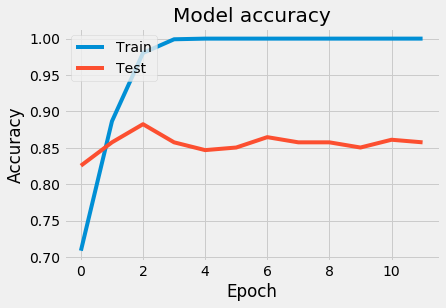

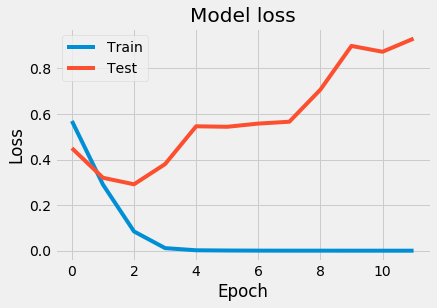

In [229]:
train_pred(model_lstm_du(embedding_matrix), epochs = 12)
#outputs.append([pred_val_y, pred_test_y, 'LSTM DU'])

In [0]:
train_pred(model_lstm_atten(embedding_matrix), epochs = 50)
#outputs.append([pred_val_y, pred_test_y, '2 LSTM w/ attention'])

Train on 1120 samples, validate on 281 samples
Epoch 1/50
1120/1120 [==============================] - 26s 23ms/step - loss: 0.6351 - acc: 0.6536 - val_loss: 0.6326 - val_acc: 0.6904
Epoch 2/50
1120/1120 [==============================] - 12s 11ms/step - loss: 0.4909 - acc: 0.7723 - val_loss: 0.3813 - val_acc: 0.8327
Epoch 3/50
1120/1120 [==============================] - 12s 11ms/step - loss: 0.3733 - acc: 0.8384 - val_loss: 0.4372 - val_acc: 0.7829
Epoch 4/50
 304/1120 [=======>......................] - ETA: 7s - loss: 0.3872 - acc: 0.8388